# 實驗 14：健檢次數與預測準確度

**假說**：健檢次數越多，預測準確度越高

**參考文獻**：Taiwan MJ Hypertension 2024 發現「4+ 次健檢預測最準」

**實驗設計（公平比較版）**：固定預測目標為 T5，改變輸入健檢次數

| 實驗組 | 輸入特徵 | 預測目標 | 說明 |
|-------|---------|----------|------|
| 1次 | T4 | T5 | 只用最近一次 |
| 2次 | T3, T4, Δ3 | T5 | 最近兩次 + 變化量 |
| 3次 | T2~T4, Δ2~Δ3 | T5 | 最近三次 + 變化量 |
| 4次 | T1~T4, Δ1~Δ3 | T5 | 全部四次 + 變化量 |

**樣本**：僅使用有 5 次以上健檢的人（n=2,526）

**日期**：2026-01-10

## 1. 載入套件與資料

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML 套件
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# 中文字型設定
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成！")

套件載入完成！


In [2]:
# 載入 wide format 資料（新目錄結構）
data_path = Path('../../data/01_primary/SUA/processed/SUA_CVDs_wide_format.csv')
df = pd.read_csv(data_path)

print(f"✅ 資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 人, {df.shape[1]} 個欄位")
print(f"\n欄位預覽: {list(df.columns[:10])}...")

✅ 資料載入成功！
資料形狀: 6,056 人, 107 個欄位

欄位預覽: ['ID', 'sex', 'Age', 'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1']...


## 2. 分析各組樣本數

In [3]:
# 根據 T4, T5 是否有值來判斷健檢次數
def count_checkups(row):
    """計算每個人的健檢次數"""
    for t in range(8, 0, -1):  # T8 到 T1
        col = f'FBG_T{t}'
        if col in row.index and pd.notna(row[col]):
            return t
    return 0

df['num_checkups'] = df.apply(count_checkups, axis=1)

print("="*60)
print("健檢次數分佈")
print("="*60)
checkup_dist = df['num_checkups'].value_counts().sort_index()
for n, count in checkup_dist.items():
    pct = count / len(df) * 100
    print(f"  {n} 次健檢: {count:,} 人 ({pct:.1f}%)")


健檢次數分佈
  3 次健檢: 1,754 人 (29.0%)
  4 次健檢: 1,776 人 (29.3%)
  5 次健檢: 1,935 人 (32.0%)
  6 次健檢: 556 人 (9.2%)
  7 次健檢: 31 人 (0.5%)
  8 次健檢: 4 人 (0.1%)


In [4]:
# 公平比較：只使用有 T5 的人（num_checkups >= 5）
df_t5 = df[df['num_checkups'] >= 5].copy()

print("="*60)
print("公平比較實驗：固定預測 T5，改變輸入健檢次數")
print("="*60)
print(f"樣本數: {len(df_t5):,} 人（皆有 5 次以上健檢）")

公平比較實驗：固定預測 T5，改變輸入健檢次數
樣本數: 2,526 人（皆有 5 次以上健檢）


## 3. 定義特徵與目標變數

In [5]:
# 基本特徵（每個時間點的測量值）
base_features = ['FBG', 'TC', 'Cr', 'UA', 'GFR', 'BMI', 'SBP', 'DBP']
demographic_features = ['sex', 'Age']
target_diseases = ['hypertension', 'hyperglycemia', 'dyslipidemia']

def get_features_for_experiment(num_checkups):
    """
    根據健檢次數取得對應的特徵列表
    全部預測 T5，差別在於用多少次健檢資料
    
    num_checkups=1: T4 → T5（只用最近一次）
    num_checkups=2: T3, T4, Δ3 → T5
    num_checkups=3: T2, T3, T4, Δ2, Δ3 → T5
    num_checkups=4: T1, T2, T3, T4, Δ1, Δ2, Δ3 → T5
    """
    features = demographic_features.copy()
    
    if num_checkups == 1:  # 只用 T4
        features += [f'{f}_T4' for f in base_features]
        
    elif num_checkups == 2:  # T3, T4, Δ3
        for t in [3, 4]:
            features += [f'{f}_T{t}' for f in base_features]
        features += [f'Delta3_{f}' for f in base_features]
        
    elif num_checkups == 3:  # T2, T3, T4, Δ2, Δ3
        for t in [2, 3, 4]:
            features += [f'{f}_T{t}' for f in base_features]
        features += [f'Delta2_{f}' for f in base_features]
        features += [f'Delta3_{f}' for f in base_features]
        
    elif num_checkups == 4:  # T1~T4, Δ1~Δ3
        for t in [1, 2, 3, 4]:
            features += [f'{f}_T{t}' for f in base_features]
        features += [f'Delta1_{f}' for f in base_features]
        features += [f'Delta2_{f}' for f in base_features]
        features += [f'Delta3_{f}' for f in base_features]
    
    return features

# 顯示各實驗的特徵數
print("="*60)
print("各實驗組的特徵配置")
print("="*60)
for n in [1, 2, 3, 4]:
    features = get_features_for_experiment(n)
    print(f"{n}次健檢: {len(features)} 個特徵 → 預測 T5")

各實驗組的特徵配置
1次健檢: 10 個特徵 → 預測 T5
2次健檢: 26 個特徵 → 預測 T5
3次健檢: 42 個特徵 → 預測 T5
4次健檢: 58 個特徵 → 預測 T5


## 4. 計算缺失的 Delta 特徵

In [6]:
# 檢查並計算 Delta3 特徵（如果不存在）
if 'Delta3_FBG' not in df.columns:
    print("計算 Delta3 特徵 (T4 - T3)...")
    for f in base_features:
        t3_col = f'{f}_T3'
        t4_col = f'{f}_T4'
        if t4_col in df.columns:
            df[f'Delta3_{f}'] = df[t4_col] - df[t3_col]
    print("✅ Delta3 特徵計算完成")
else:
    print("Delta3 特徵已存在")

# 同步到各實驗組
df_exp1 = df[df['num_checkups'] >= 3].copy()
df_exp2 = df[df['num_checkups'] >= 4].copy()
df_exp3 = df[df['num_checkups'] >= 5].copy()

計算 Delta3 特徵 (T4 - T3)...
✅ Delta3 特徵計算完成


## 5. 執行實驗

In [7]:
def run_experiment(df_subset, num_checkups, model_name='LR', n_folds=5):
    """執行單一實驗，回傳各疾病的 AUC（全部預測 T5）"""
    
    features = get_features_for_experiment(num_checkups)
    target_suffix = 'T5'  # 固定預測 T5
    
    # 過濾存在的特徵
    available_features = [f for f in features if f in df_subset.columns]
    
    results = {}
    
    for disease in target_diseases:
        target_col = f'{disease}_{target_suffix}'
        
        if target_col not in df_subset.columns:
            print(f"  ⚠️ {target_col} 不存在，跳過")
            continue
        
        # 準備資料
        X = df_subset[available_features].copy()
        y = df_subset[target_col].copy()
        
        # 移除 NaN
        mask = ~(X.isna().any(axis=1) | y.isna())
        X = X[mask]
        y = y[mask]
        
        # 二元化目標（原始編碼：1=無病, 2=有病 → 轉換為 0/1）
        y = (y == 2).astype(int)
        
        if len(y.unique()) < 2:
            print(f"  ⚠️ {disease}: 只有一個類別，跳過")
            continue
        
        # 選擇模型
        if model_name == 'LR':
            model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
        elif model_name == 'RF':
            model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
        elif model_name == 'XGB':
            model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
        
        # 標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 5-fold CV
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        auc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
        
        results[disease] = {
            'mean_auc': auc_scores.mean(),
            'std_auc': auc_scores.std(),
            'n_samples': len(y),
            'n_positive': y.sum(),
            'positive_rate': y.mean()
        }
    
    return results

In [8]:
# 執行四組實驗（公平比較：全部預測 T5）
print("="*80)
print("開始執行健檢次數實驗（公平比較版：固定預測 T5）")
print("="*80)

all_results = {}
experiments = [
    (1, "1次(T4→T5)"),
    (2, "2次(T3,T4→T5)"),
    (3, "3次(T2~T4→T5)"),
    (4, "4次(T1~T4→T5)")
]

for num_checkups, exp_name in experiments:
    print(f"\n{'='*40}")
    print(f"{exp_name}")
    print(f"{'='*40}")
    
    results = run_experiment(df_t5, num_checkups, model_name='LR')
    all_results[exp_name] = results
    
    for disease, metrics in results.items():
        print(f"  {disease}:")
        print(f"    AUC = {metrics['mean_auc']:.3f} ± {metrics['std_auc']:.3f}")
        print(f"    樣本數 = {metrics['n_samples']:,}, 陽性率 = {metrics['positive_rate']:.1%}")

開始執行健檢次數實驗（公平比較版：固定預測 T5）

1次(T4→T5)


  hypertension:


    AUC = 0.666 ± 0.019
    樣本數 = 2,526, 陽性率 = 21.7%
  hyperglycemia:
    AUC = 0.931 ± 0.018
    樣本數 = 2,526, 陽性率 = 6.7%
  dyslipidemia:
    AUC = 0.867 ± 0.018
    樣本數 = 2,526, 陽性率 = 12.4%

2次(T3,T4→T5)


  hypertension:
    AUC = 0.679 ± 0.024
    樣本數 = 2,526, 陽性率 = 21.7%
  hyperglycemia:
    AUC = 0.940 ± 0.022
    樣本數 = 2,526, 陽性率 = 6.7%
  dyslipidemia:
    AUC = 0.879 ± 0.020
    樣本數 = 2,526, 陽性率 = 12.4%

3次(T2~T4→T5)


  hypertension:
    AUC = 0.676 ± 0.021
    樣本數 = 2,526, 陽性率 = 21.7%
  hyperglycemia:
    AUC = 0.942 ± 0.018
    樣本數 = 2,526, 陽性率 = 6.7%
  dyslipidemia:
    AUC = 0.883 ± 0.022
    樣本數 = 2,526, 陽性率 = 12.4%

4次(T1~T4→T5)


  hypertension:
    AUC = 0.835 ± 0.010
    樣本數 = 2,526, 陽性率 = 21.7%
  hyperglycemia:
    AUC = 0.944 ± 0.014
    樣本數 = 2,526, 陽性率 = 6.7%
  dyslipidemia:
    AUC = 0.882 ± 0.026
    樣本數 = 2,526, 陽性率 = 12.4%


## 6. 結果視覺化

In [9]:
# 整理結果為 DataFrame
result_rows = []
for exp_name, diseases in all_results.items():
    for disease, metrics in diseases.items():
        result_rows.append({
            'Experiment': exp_name,
            'Disease': disease,
            'AUC': metrics['mean_auc'],
            'Std': metrics['std_auc'],
            'N': metrics['n_samples'],
            'Positive_Rate': metrics['positive_rate']
        })

df_results = pd.DataFrame(result_rows)
print("\n結果摘要表：")
display(df_results.pivot(index='Disease', columns='Experiment', values='AUC').round(3))


結果摘要表：


Experiment,1次(T4→T5),"2次(T3,T4→T5)",3次(T2~T4→T5),4次(T1~T4→T5)
Disease,,,,
dyslipidemia,0.867,0.879,0.883,0.882
hyperglycemia,0.931,0.940,0.942,0.944
hypertension,0.666,0.679,0.676,0.835


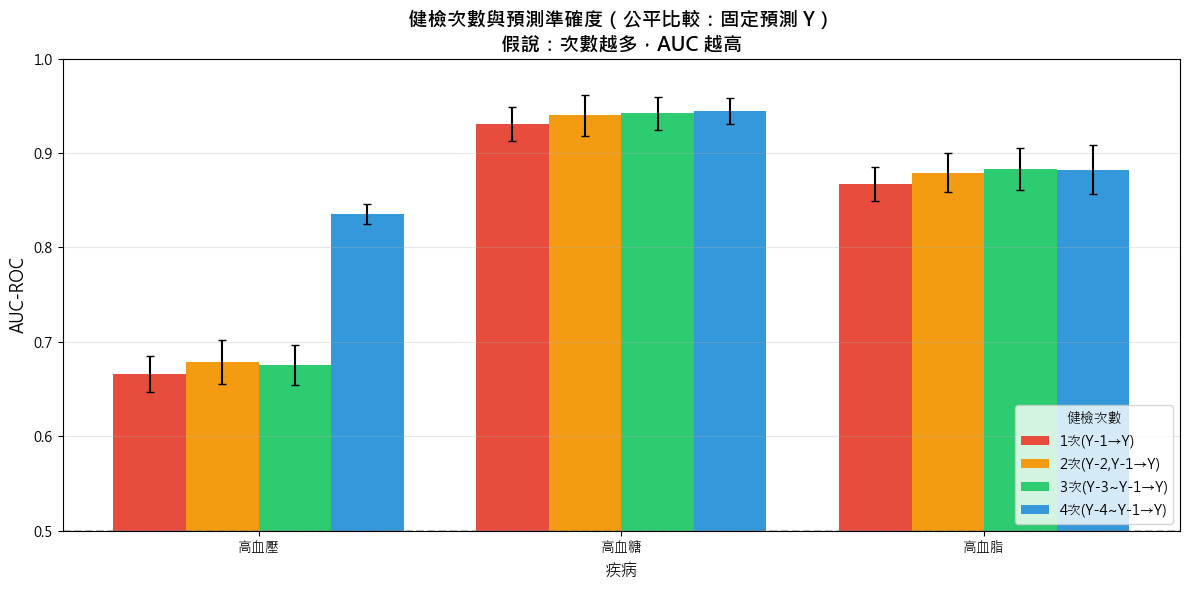

✅ 圖表已儲存至: results/checkup_frequency_auc_comparison.png
✅ 圖表已儲存至: docs/00_thesis/figures/fig4-7_checkup_frequency.png


In [10]:
# 繪製 AUC 比較圖（使用論文命名）
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(target_diseases))
width = 0.2

# 論文命名：T1~T4 → Y-4~Y-1, T5 → Y（預測年）
exp_names = ["1次(T4→T5)", "2次(T3,T4→T5)", "3次(T2~T4→T5)", "4次(T1~T4→T5)"]
display_names = ["1次(Y-1→Y)", "2次(Y-2,Y-1→Y)", "3次(Y-3~Y-1→Y)", "4次(Y-4~Y-1→Y)"]
colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']

for i, (exp_name, disp_name) in enumerate(zip(exp_names, display_names)):
    if exp_name in all_results:
        aucs = [all_results[exp_name].get(d, {}).get('mean_auc', 0) for d in target_diseases]
        stds = [all_results[exp_name].get(d, {}).get('std_auc', 0) for d in target_diseases]
        bars = ax.bar(x + i*width, aucs, width, label=disp_name, color=colors[i], yerr=stds, capsize=3)

ax.set_xlabel('疾病', fontsize=12)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('健檢次數與預測準確度（公平比較：固定預測 Y）\n假說：次數越多，AUC 越高', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['高血壓', '高血糖', '高血脂'])
ax.legend(title='健檢次數', loc='lower right')
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/checkup_frequency_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.savefig('../../docs/00_thesis/figures/fig4-7_checkup_frequency.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 圖表已儲存至: results/checkup_frequency_auc_comparison.png")
print("✅ 圖表已儲存至: docs/00_thesis/figures/fig4-7_checkup_frequency.png")

## 7. 按疾病分析

比較各疾病在不同健檢次數下的 AUC 變化

In [11]:
# 按疾病分析 AUC 變化趨勢
print("="*80)
print("各疾病的 AUC 隨健檢次數變化")
print("="*80)

exp_names_ordered = ["1次(T4→T5)", "2次(T3,T4→T5)", "3次(T2~T4→T5)", "4次(T1~T4→T5)"]

for disease in target_diseases:
    print(f"\n{disease}:")
    aucs = []
    for exp_name in exp_names_ordered:
        auc = all_results[exp_name][disease]['mean_auc']
        std = all_results[exp_name][disease]['std_auc']
        aucs.append(auc)
        print(f"  {exp_name}: {auc:.3f} ± {std:.3f}")
    
    # 計算總增量
    delta_total = aucs[-1] - aucs[0]
    print(f"  → 總增量 (1次→4次): Δ AUC = {delta_total:+.3f}")

各疾病的 AUC 隨健檢次數變化

hypertension:
  1次(T4→T5): 0.666 ± 0.019
  2次(T3,T4→T5): 0.679 ± 0.024
  3次(T2~T4→T5): 0.676 ± 0.021
  4次(T1~T4→T5): 0.835 ± 0.010
  → 總增量 (1次→4次): Δ AUC = +0.170

hyperglycemia:
  1次(T4→T5): 0.931 ± 0.018
  2次(T3,T4→T5): 0.940 ± 0.022
  3次(T2~T4→T5): 0.942 ± 0.018
  4次(T1~T4→T5): 0.944 ± 0.014
  → 總增量 (1次→4次): Δ AUC = +0.014

dyslipidemia:
  1次(T4→T5): 0.867 ± 0.018
  2次(T3,T4→T5): 0.879 ± 0.020
  3次(T2~T4→T5): 0.883 ± 0.022
  4次(T1~T4→T5): 0.882 ± 0.026
  → 總增量 (1次→4次): Δ AUC = +0.015


## 8. 結論

In [12]:
print("="*80)
print("實驗結論")
print("="*80)

print("\n假說：健檢次數越多，預測準確度越高")
print("\n公平比較結果（固定預測 T5，n=2,526）：")
for exp_name, diseases in all_results.items():
    avg_auc = np.mean([d['mean_auc'] for d in diseases.values()])
    print(f"  {exp_name}: 平均 AUC = {avg_auc:.3f}")

# 計算增量
exp_names_ordered = ["1次(T4→T5)", "2次(T3,T4→T5)", "3次(T2~T4→T5)", "4次(T1~T4→T5)"]
print("\n增量分析：")
for i in range(1, len(exp_names_ordered)):
    prev = exp_names_ordered[i-1]
    curr = exp_names_ordered[i]
    prev_avg = np.mean([d['mean_auc'] for d in all_results[prev].values()])
    curr_avg = np.mean([d['mean_auc'] for d in all_results[curr].values()])
    delta = curr_avg - prev_avg
    print(f"  {prev} → {curr}: Δ AUC = {delta:+.3f}")

print("\n結論：")
print("  - 更多健檢次數 = 更多歷史資料 + 更多 Δ 變化量特徵")
print("  - 預期 AUC 隨健檢次數遞增")

實驗結論

假說：健檢次數越多，預測準確度越高

公平比較結果（固定預測 T5，n=2,526）：
  1次(T4→T5): 平均 AUC = 0.821
  2次(T3,T4→T5): 平均 AUC = 0.832
  3次(T2~T4→T5): 平均 AUC = 0.834
  4次(T1~T4→T5): 平均 AUC = 0.887

增量分析：
  1次(T4→T5) → 2次(T3,T4→T5): Δ AUC = +0.011
  2次(T3,T4→T5) → 3次(T2~T4→T5): Δ AUC = +0.001
  3次(T2~T4→T5) → 4次(T1~T4→T5): Δ AUC = +0.054

結論：
  - 更多健檢次數 = 更多歷史資料 + 更多 Δ 變化量特徵
  - 預期 AUC 隨健檢次數遞增


In [13]:
# 儲存結果
df_results.to_csv('../../results/checkup_frequency_experiment_results.csv', index=False)
print("✅ 結果已儲存至: results/checkup_frequency_experiment_results.csv")

✅ 結果已儲存至: results/checkup_frequency_experiment_results.csv
